# Pump It Up: Data Mining the Water Table 

Competition hosted by DrivenData 

## Import the dataset and relevant libraries 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

from random import randint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
pd.set_option('chained',None)

In [2]:
%cd PumpItUp

/Users/Jackie/Desktop/PumpItUp


In [371]:
training_values = pd.read_csv('training_values.csv')
training_labels = pd.read_csv('training_labels.csv')
test_values = pd.read_csv('test_values.csv')

## Explore the data

Check out the features and the labels

### Features

In [368]:
training_values.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [555]:
test_values.shape

(14850, 41)

In [315]:
training_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [316]:
training_values.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Labels

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


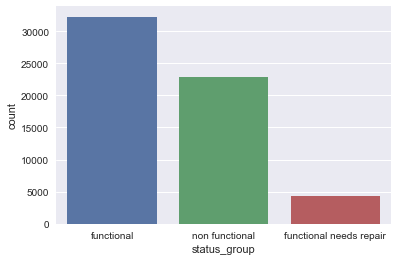

In [369]:
print(training_labels['status_group'].value_counts())
sns.countplot(x = 'status_group', data = training_labels)

In [620]:
training_labels[:5]

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## Visualizing the labels of the waterpoints on a map

I used coordinates found at http://boundingbox.klokantech.com/ and Basemap to make my map showing the location of waterpoints and their labels.

In [4]:
label_enc = LabelEncoder()
label_enc.fit(training_labels['status_group'])
print(list(label_enc.classes_))
encoded_labels = label_enc.transform(training_labels['status_group'])

['functional', 'functional needs repair', 'non functional']


/Users/Jackie/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/Jackie/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Jackie/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


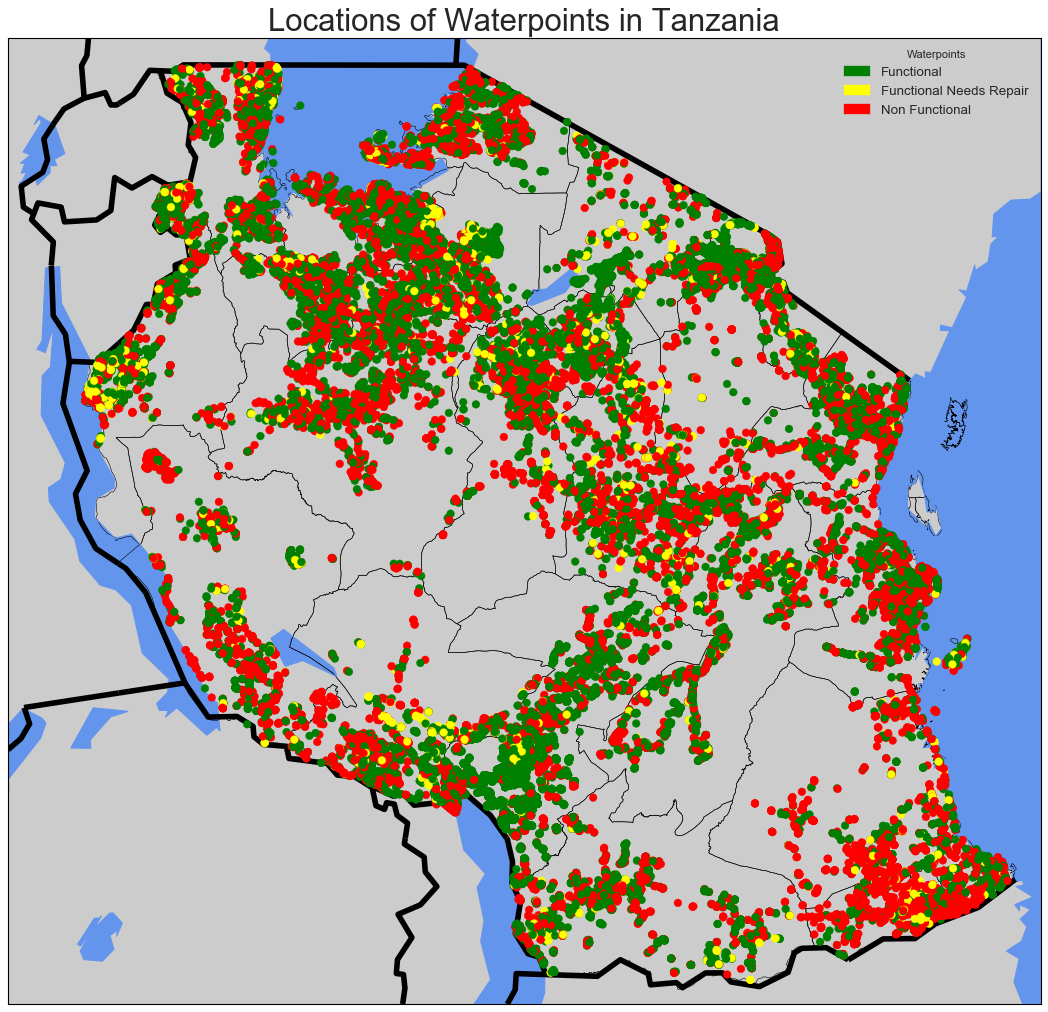

In [5]:
fig = plt.figure(figsize = (18, 16), dpi = 80)
m = Basemap(resolution = 'l', projection = 'cyl', 
            lat_0 = -6.1722100, lon_0 = 35.7394700, 
            llcrnrlon = 28.71, llcrnrlat = -11.93, 
            urcrnrlon = 40.73, urcrnrlat = -0.68)
m.drawcoastlines(color = 'cornflowerblue')
m.drawmapboundary(fill_color = 'cornflowerblue')
m.drawcountries(linewidth = 5.0, color = 'black')
m.fillcontinents(lake_color = 'cornflowerblue', zorder = 0)
m.readshapefile('Tanzania_regions_2014', 'regions', zorder = 1)

lats = training_values.latitude.values
lons = training_values.longitude.values
labels = encoded_labels
colors = ['green', 'yellow', 'red']

x, y = m(lons, lats)
m.scatter(x, y, c = labels, cmap = matplotlib.colors.ListedColormap(colors), zorder = 2)
plt.title('Locations of Waterpoints in Tanzania', fontsize = 28)
green = mpatches.Patch(color = 'green', label = 'Functional')
yellow = mpatches.Patch(color = 'yellow', label = 'Functional Needs Repair')
red = mpatches.Patch(color = 'red', label = 'Non Functional')
plt.legend(handles = [green, yellow, red], title = 'Waterpoints', loc = 1, 
           shadow = True, fontsize = 'large')

plt.show()

## Feature Selection and Feature Engineering

Many of the features were exact replicas of other feature columns (quantity and quantity_group). Other features like amount_tsh had 0 listed for 70% of the data. I chose only to work with the features: 

'district_code', 'extraction_type', 'quantity', 'source', 'gps_height', 'public_meeting', 'waterpoint_type', 'funder', 'installer', 'construction_year', 'month', 'permit', 'management', 'payment', 'latitude', 'longitude', 'population', 'water_quality', 'basin'

### longitude, latitude, and gps_height

There are 1812 timems that zero was entered for longitude. Everytime longitude was recorded as zero, latitude was recorded as -2.000000e-08, and gps_height was recorded as zero. 

To replace the zero longitudes with something semi-accurate, I computed the mean longitude and latitude for each region and saved them to a dictionary. Then, when an instance of a zero longitude was found, I could replace it with the mean long of the region that waterpoint existed.

In [186]:
training_values[training_values["longitude"] == 0.0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,other,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
256,33500,0.0,2011-07-18,Hesawa,0,DWE,0.0,-2.000000e-08,Bombani,0,...,never pay,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump
285,71487,0.0,2012-10-25,Ridep,0,DWE,0.0,-2.000000e-08,Nyanguruma,0,...,on failure,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
301,70379,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Nersing College,0,...,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
306,59713,0.0,2011-07-30,Plan International,0,Plan Internationa,0.0,-2.000000e-08,Petro,0,...,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
321,45415,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Upendo,0,...,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [372]:
""" made a small region dataframe including latitudes and longitudes to make things 
a little easier when making the dictionary """

region_df = training_values[['region_code', 'longitude', 'latitude', 'gps_height']].copy()
region_df = region_df.sort_values(['region_code'])
region_df[:5]

,region_code,longitude,latitude,gps_height
31023,1,36.040140,-4.729822,0
10601,1,36.479069,-6.174439,0
54054,1,36.489771,-7.104349,0
39734,1,35.830580,-4.381180,0
39723,1,35.993264,-7.026813,0


In [373]:
# calculates mean latitude and longitude for each region
def region_mean(df):
    old_region = None
    lats = []
    longs = []
    hts = []
    region_dict = {}
    
    for index, row in df.iterrows():
        this_region = int(row['region_code'])
        this_lat = float(row['latitude'])
        this_long = float(row['longitude'])
        this_ht = float(row['gps_height'])
        
        # if this is the first in a region
        if old_region and old_region != this_region:
            
            # printing out the previous region's mean_lat and mean_long
            mean_lat = float(np.mean(lats))
            mean_long = float(np.mean(longs))
            mean_ht = float(np.mean(hts))
            #print('%s mean lat: %f, mean long: %f' % (old_region, mean_lat, mean_long))
            region_dict[old_region] = {}
            region_dict[old_region]['mean_lat'] = mean_lat
            region_dict[old_region]['mean_long'] = mean_long
            region_dict[old_region]['mean_ht'] = mean_ht
            
            # reset mean_lat and mean_long
            lats = []
            longs = []
            hts = []
        
        # update region
        old_region = this_region
        
        # this region is the same as last region, append lats and longs
        lats.append(this_lat)
        longs.append(this_long)
        hts.append(this_ht)
        
    # print out very last region
    if old_region != None:
        mean_lat = float(np.mean(lats))
        mean_long = float(np.mean(longs))
        mean_ht = float(np.mean(hts))
        #print('%s mean lat: %f, mean long: %f' % (old_region, mean_lat, mean_long))
        region_dict[old_region] = {}
        region_dict[old_region]['mean_lat'] = mean_lat
        region_dict[old_region]['mean_long'] = mean_long
        region_dict[old_region]['mean_ht'] = mean_ht
        
    return region_dict

In [374]:
region_dict = region_mean(region_df)

In [375]:
print(region_dict.get(2))

{'mean_lat': -3.231962549540344, 'mean_long': 36.648737683581345, 'mean_ht': 1393.4966931216932}


In [376]:
def replace_zeros(df, dictionary):
    
    for index, row in df.iterrows():
        region = int(row['region_code'])
        
        if row['longitude'] == 0.0:
            df.loc[index, 'longitude'] = region_dict.get(region).get('mean_long')
            df.loc[index, 'latitude'] = region_dict.get(region).get('mean_lat')
            df.loc[index, 'gps_height'] = region_dict.get(region).get('mean_ht')
            
    return df

In [377]:
training_values = replace_zeros(training_values, region_dict)
test_values = replace_zeros(test_values, region_dict)

### date_recorded

The rainy season is in March, April, and May. Maybe if the waterpoint information was collected during one of those months is affects the label of the waterpoint. I added a month column using the date_recorded feature to determine if recording data during the rainy season made an impact on waterpoint status classification

https://www.expertafrica.com/tanzania/info/tanzania-weather-and-climate

In [378]:
training_values['month'] = 0
test_values['month'] = 0

In [379]:
# this function takes a very long time to run -- need to find something faster

def find_month(df):
    
    for index, row in df.iterrows():
        date = df.loc[index, 'date_recorded']
        year, month, day = str(date).split('-')
        df.loc[index, 'month'] = int(month)
            
    return df

In [380]:
training_values = find_month(training_values)
test_values = find_month(test_values)

In [381]:
test_values[:5]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month
0,50785,0.0,2013-02-04,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2
1,51630,0.0,2013-02-04,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2
2,17168,0.0,2013-02-01,NaN,1567.0,NaN,34.767863,-5.004344,Puma Secondary,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2
3,45559,0.0,2013-01-22,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,1
4,49871,500.0,2013-03-27,Bruder,1260.0,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3


### construction_year

There are 20709 instances of zero recorded as the construction year of the waterpoint in the training set.  I replaced the zeros in construction_year with the median (2000)

In [382]:
training_values.construction_year = training_values['construction_year'].replace(0, np.NaN)

### population

Zero was entered 21381 times for population in the training set, I replaced the zeros in population with the median (150)

In [383]:
training_values.population = training_values['population'].replace(0, np.NaN)

### gps_height

Replacing the actual gps_height with a height range

In [384]:
training_values.gps_height = training_values.gps_height.apply(lambda x: '>500' if x > 500
                                                              else '0 to 500' if x > 0
                                                              else '0 or below')

test_values.gps_height = test_values.gps_height.apply(lambda x: '>500' if x > 500
                                                              else '0 to 500' if x > 0
                                                              else '0 or below')

In [385]:
training_values['gps_height'].value_counts()

>500          27720
0 or below    20122
0 to 500      11558
Name: gps_height, dtype: int64

In [332]:
training_values.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management            0
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### installer 

Replacing the 3655 times installer was entered as NaN with the mode, DWE.

### public_meeting

In [392]:
training_values.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population               21381
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

## Split data into training and test sets

In [386]:
X = training_values[['district_code', 'extraction_type', 'quantity', 'source', 'gps_height', 
                     'public_meeting', 'waterpoint_type', 'funder', 'installer', 
                     'construction_year', 'month', 'permit', 'management', 'payment', 
                     'latitude', 'longitude', 'population', 'water_quality', 'basin']]

y = training_labels['status_group']

X_test_data = test_values[['district_code', 'extraction_type', 'quantity', 'source', 'gps_height', 
                           'public_meeting', 'waterpoint_type', 'funder', 'installer', 
                           'construction_year', 'month', 'permit', 'management', 'payment', 
                           'latitude', 'longitude', 'population', 'water_quality', 'basin']]

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)

## Categorical feature encoding

In [388]:
X_train = pd.get_dummies(X_train[['district_code', 'extraction_type', 'quantity', 'source', 
                                  'public_meeting', 'waterpoint_type', 'funder', 'gps_height',
                                  'installer', 'month', 'permit', 'management', 'payment', 
                                  'water_quality', 'basin']])

X_test = pd.get_dummies(X_test[['district_code', 'extraction_type', 'quantity', 'source', 
                                'public_meeting', 'waterpoint_type', 'funder', 'gps_height',
                                'installer', 'month', 'permit', 'management', 'payment', 
                                'water_quality', 'basin']])

X_test_data = pd.get_dummies(X_test_data[['district_code', 'extraction_type', 'quantity', 'source', 
                                          'public_meeting', 'waterpoint_type', 'funder', 'gps_height',
                                          'installer', 'month', 'permit', 'management', 'payment', 
                                          'water_quality', 'basin']])

missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

missing_cols = set(X_train.columns) - set(X_test_data.columns)
for c in missing_cols:
    X_test_data[c] = 0
X_test_data = X_test_data[X_train.columns]

In [389]:
print(X_train.shape)
print(X_test_data.shape)

(41580, 3431)
(14850, 3431)


## Random Forest Classifier

In [390]:
rf_classifier = RandomForestClassifier(n_estimators = 60, criterion = 'entropy',
                                       min_samples_split = 6, 
                                       random_state = 6)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=1, oob_score=False, random_state=6,
            verbose=0, warm_start=False)

In [391]:
rf_y_pred = rf_classifier.predict(X_test)
rf_score = rf_classifier.score(X_test, y_test)
print('Random Forest Classifier Mean Accuracy:', rf_score)

Random Forest Classifier Mean Accuracy: 0.794219977553


## Make a prediction on the test data

In [149]:
predictions = rf_classifier.predict(X_test_data)

In [150]:
print(predictions)

['functional' 'functional' 'functional' ..., 'functional' 'functional'
 'non functional']


In [151]:
test_ids = np.array(test_values['id'].astype(int))
solution = pd.DataFrame(predictions, test_ids, columns = ['status_group'])

In [152]:
print(solution.head())
print(solution.shape)

         status_group
50785      functional
51630      functional
17168      functional
45559  non functional
49871      functional
(14850, 1)


In [153]:
solution.to_csv('solution4.csv', index_label = ['id'])